claude

In [1]:
# 셀 1: 필요한 라이브러리 import
import os
import json
import re
import time
from typing import List, Dict, Any, Optional, Union, Tuple, Set
from dataclasses import dataclass, field
from datetime import datetime
from tqdm.notebook import tqdm
import pandas as pd

# 외부 라이브러리
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from neo4j import GraphDatabase
from openai import OpenAI

In [3]:
# 셀 2: 환경 설정 및 기본 변수 정의
# .env 파일 로드
load_dotenv()

# 환경 변수 가져오기
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USERNAME = os.getenv("NEO4J_USERNAME")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# 임베딩 모델 설정
embedding_model = OpenAIEmbeddings(model='text-embedding-3-small', api_key=OPENAI_API_KEY)
embedding_dimension = 1536  # text-embedding-3-small 차원

# 데이터 경로 설정
pdf_path = './dataset/criminal-law.pdf'
precedent_dir = './dataset/precedent_label/'
output_dir = 'results'
os.makedirs(output_dir, exist_ok=True)

In [4]:
# 셀 3: 데이터 모델 클래스
@dataclass
class Article:
    """법조항 정보를 담는 클래스"""
    id: str
    text: str
    embedding: Optional[List[float]] = None
    
    def to_dict(self) -> Dict[str, Any]:
        """딕셔너리 변환"""
        return {
            "id": self.id,
            "text": self.text,
            "embedding": self.embedding
        }


@dataclass
class Precedent:
    """판례 정보를 담는 클래스"""
    id: str
    name: Optional[str] = None
    judgment_summary: Optional[str] = None
    full_summary: Optional[str] = None
    keywords: List[str] = field(default_factory=list)
    referenced_rules: List[str] = field(default_factory=list)
    referenced_cases: List[str] = field(default_factory=list)
    embedding: Optional[List[float]] = None
    
    def to_dict(self) -> Dict[str, Any]:
        """딕셔너리 변환"""
        return {
            "id": self.id,
            "name": self.name,
            "judgment_summary": self.judgment_summary,
            "full_summary": self.full_summary,
            "keywords": self.keywords,
            "referenced_rules": self.referenced_rules,
            "referenced_cases": self.referenced_cases,
            "embedding": self.embedding
        }


@dataclass
class SearchResult:
    """검색 결과를 담는 클래스"""
    id: str
    type: str  # "Article" 또는 "Precedent"
    score: float
    text: str
    metadata: Dict[str, Any] = field(default_factory=dict)
    
    def to_dict(self) -> Dict[str, Any]:
        """딕셔너리 변환"""
        return {
            "id": self.id,
            "type": self.type,
            "score": self.score,
            "text": self.text,
            "metadata": self.metadata
        }


In [5]:
# 셀 4: Neo4j 리포지토리 베이스 클래스
class Neo4jRepository:
    """Neo4j 데이터베이스 연결 및 기본 작업을 위한 베이스 클래스"""
    
    def __init__(self, uri: str, username: str, password: str, database: str = "neo4j"):
        """Neo4j 연결 초기화
        
        Args:
            uri: Neo4j 서버 URI
            username: 사용자명
            password: 비밀번호
            database: 데이터베이스 이름
        """
        self.uri = uri
        self.username = username
        self.password = password
        self.database = database
        self.driver = None
        
    def connect(self) -> None:
        """Neo4j 데이터베이스에 연결"""
        try:
            self.driver = GraphDatabase.driver(
                self.uri, 
                auth=(self.username, self.password)
            )
            self.driver.verify_connectivity()
            print("Successfully connected to Neo4j.")
        except Exception as e:
            print(f"Failed to connect to Neo4j: {e}")
            raise
    
    def close(self) -> None:
        """연결 종료"""
        if self.driver:
            self.driver.close()
            self.driver = None
            print("Neo4j connection closed.")
    
    def run_query(self, query: str, parameters: Dict[str, Any] = None) -> List[Dict[str, Any]]:
        """Neo4j 쿼리 실행
        
        Args:
            query: Cypher 쿼리
            parameters: 쿼리 파라미터
            
        Returns:
            쿼리 결과
        """
        if not self.driver:
            self.connect()
            
        with self.driver.session(database=self.database) as session:
            result = session.run(query, parameters or {})
            return [record.data() for record in result]
            
    def setup_constraints_and_indexes(self, embedding_dimension: int) -> None:
        """제약조건 및 인덱스 설정
        
        Args:
            embedding_dimension: 임베딩 벡터 차원
        """
        try:
            # 고유성 제약조건 설정
            self.run_query("CREATE CONSTRAINT article_id IF NOT EXISTS FOR (a:Article) REQUIRE a.id IS UNIQUE")
            self.run_query("CREATE CONSTRAINT precedent_id IF NOT EXISTS FOR (p:Precedent) REQUIRE p.id IS UNIQUE")
            self.run_query("CREATE CONSTRAINT keyword_text IF NOT EXISTS FOR (k:Keyword) REQUIRE k.text IS UNIQUE")
            
            # 벡터 인덱스 생성
            try:
                self.run_query(
                    "CREATE VECTOR INDEX article_embedding IF NOT EXISTS "
                    "FOR (a:Article) ON (a.embedding) "
                    f"OPTIONS {{indexConfig: {{`vector.dimensions`: {embedding_dimension}, `vector.similarity_function`: 'cosine'}}}}"
                )
                print("Article vector index created or already exists.")
            except Exception as e:
                print(f"Error creating Article vector index: {e}")
                
            try:
                self.run_query(
                    "CREATE VECTOR INDEX precedent_embedding IF NOT EXISTS "
                    "FOR (p:Precedent) ON (p.embedding) "
                    f"OPTIONS {{indexConfig: {{`vector.dimensions`: {embedding_dimension}, `vector.similarity_function`: 'cosine'}}}}"
                )
                print("Precedent vector index created or already exists.")
            except Exception as e:
                print(f"Error creating Precedent vector index: {e}")
                
            # 인덱스가 활성화될 때까지 대기
            print("Waiting for indexes to populate...")
            self.run_query("CALL db.awaitIndexes(300)")
            print("Indexes should be online.")
        except Exception as e:
            print(f"Error setting up constraints and indexes: {e}")
            raise

In [6]:
# 셀 5: ArticleRepository 클래스
class ArticleRepository(Neo4jRepository):
    """법조항 관련 데이터베이스 작업을 처리하는 클래스"""
    
    def create_article(self, article: Article) -> None:
        """법조항 노드 생성
        
        Args:
            article: 법조항 객체
        """
        query = """
        MERGE (a:Article {id: $article_id})
        SET a.text = $content,
            a.embedding = $embedding
        """
        self.run_query(
            query,
            {
                "article_id": article.id,
                "content": article.text,
                "embedding": article.embedding
            }
        )
    
    def create_bulk_articles(self, articles: List[Article], batch_size: int = 50) -> int:
        """다수의 법조항 노드 생성
        
        Args:
            articles: 법조항 객체 리스트
            batch_size: 배치 크기
            
        Returns:
            생성된 법조항 수
        """
        count = 0
        start_time = time.time()
        
        for i in range(0, len(articles), batch_size):
            batch = articles[i:i+batch_size]
            
            for article in batch:
                if not article.text:
                    print(f"Skipping article {article.id} due to empty content.")
                    continue
                    
                try:
                    self.create_article(article)
                    count += 1
                except Exception as e:
                    print(f"Error processing article {article.id}: {e}")
            
            if (i + batch_size) % (batch_size * 5) == 0:
                print(f"  Processed {i + batch_size}/{len(articles)} articles...")
                
        end_time = time.time()
        print(f"Finished creating {count} Article nodes in {end_time - start_time:.2f} seconds.")
        
        return count
    
    def find_article_by_id(self, article_id: str) -> Optional[Article]:
        """ID로 법조항 찾기
        
        Args:
            article_id: 법조항 ID
            
        Returns:
            법조항 객체 또는 None
        """
        query = """
        MATCH (a:Article {id: $article_id})
        RETURN a.id as id, a.text as text, a.embedding as embedding
        """
        results = self.run_query(query, {"article_id": article_id})
        
        if not results:
            return None
            
        result = results[0]
        return Article(
            id=result["id"],
            text=result["text"],
            embedding=result["embedding"]
        )
    
    def search_articles_by_vector(self, query_embedding: List[float], limit: int = 5) -> List[SearchResult]:
        """벡터 유사도 기반 법조항 검색
        
        Args:
            query_embedding: 쿼리 임베딩
            limit: 최대 결과 수
            
        Returns:
            검색 결과 리스트
        """
        query = """
        CALL db.index.vector.queryNodes('article_embedding', $limit, $query_embedding) 
        YIELD node, score
        RETURN node.id AS id, node.text AS text, score
        """
        results = self.run_query(
            query,
            {
                "limit": limit,
                "query_embedding": query_embedding
            }
        )
        
        return [
            SearchResult(
                id=result["id"],
                type="Article",
                score=result["score"],
                text=result["text"]
            )
            for result in results
        ]
    
    def search_articles_related_to_precedents(self, query_embedding: List[float], top_k: int = 8) -> List[SearchResult]:
        """판례 관계를 고려한 법조항 검색
        
        Args:
            query_embedding: 쿼리 임베딩
            top_k: 최대 결과 수
            
        Returns:
            검색 결과 리스트
        """
        query = """
        // 1. 벡터 검색으로 시작 법조항 찾기
        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) 
        YIELD node as article, score as article_score
        
        // 2. 해당 법조항과 연결된 판례와 키워드 찾기
        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)
        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)
        
        // 3. 결과 집계 및 점수 계산
        WITH article, article_score, precedent, 
             collect(DISTINCT keyword.text) as keywords,
             count(precedent) as precedent_count
        
        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스
        WITH article, article_score + (precedent_count * 0.01) as final_score,
             precedent_count, keywords
        
        RETURN article.id as id, 
               article.text as text, 
               final_score as score,
               precedent_count,
               keywords
        ORDER BY final_score DESC
        LIMIT $top_k
        """
        
        results = self.run_query(
            query,
            {
                "top_k": top_k,
                "query_embedding": query_embedding
            }
        )
        
        return [
            SearchResult(
                id=result["id"],
                type="Article",
                score=result["score"],
                text=result["text"],
                metadata={
                    "precedent_count": result["precedent_count"],
                    "related_keywords": result["keywords"]
                }
            )
            for result in results
        ]

In [7]:
# 셀 6: PrecedentRepository 클래스
class PrecedentRepository(Neo4jRepository):
    """판례 관련 데이터베이스 작업을 처리하는 클래스"""
    
    def create_precedent(self, precedent: Precedent) -> None:
        """판례 노드 생성
        
        Args:
            precedent: 판례 객체
        """
        query = """
        MERGE (p:Precedent {id: $case_id})
        SET p.name = $case_name,
            p.judgment_summary = $judgment_summary,
            p.full_summary = $full_summary,
            p.embedding = $embedding
        """
        self.run_query(
            query,
            {
                "case_id": precedent.id,
                "case_name": precedent.name,
                "judgment_summary": precedent.judgment_summary,
                "full_summary": precedent.full_summary,
                "embedding": precedent.embedding
            }
        )
        
        # 키워드 노드 생성 및 관계 설정
        for keyword_text in precedent.keywords:
            self.run_query(
                """
                MERGE (k:Keyword {text: $keyword_text})
                WITH k
                MATCH (p:Precedent {id: $case_id})
                MERGE (p)-[:HAS_KEYWORD]->(k)
                """,
                {
                    "keyword_text": keyword_text,
                    "case_id": precedent.id
                }
            )
            
        # 참조 법조항 관계 설정
        for article_id_ref in precedent.referenced_rules:
            self.run_query(
                """
                MATCH (p:Precedent {id: $case_id})
                MATCH (a:Article)
                WHERE a.id STARTS WITH $article_id_ref
                MERGE (p)-[:REFERENCES_ARTICLE]->(a)
                """,
                {
                    "case_id": precedent.id,
                    "article_id_ref": article_id_ref
                }
            )
    
    def create_bulk_precedents(self, precedents: List[Precedent], batch_size: int = 50) -> int:
        """다수의 판례 노드 생성
        
        Args:
            precedents: 판례 객체 리스트
            batch_size: 배치 크기
            
        Returns:
            생성된 판례 수
        """
        count = 0
        start_time = time.time()
        
        for i in range(0, len(precedents), batch_size):
            batch = precedents[i:i+batch_size]
            
            for precedent in batch:
                text_to_embed = precedent.full_summary or precedent.judgment_summary
                if not text_to_embed:
                    print(f"Skipping precedent {precedent.id} due to empty summary.")
                    continue
                    
                try:
                    self.create_precedent(precedent)
                    count += 1
                except Exception as e:
                    print(f"Error processing precedent {precedent.id}: {e}")
            
            if (i + batch_size) % (batch_size * 2) == 0:
                print(f"  Processed {i + batch_size}/{len(precedents)} precedents...")
                
        end_time = time.time()
        print(f"Finished creating {count} Precedent nodes in {end_time - start_time:.2f} seconds.")
        
        return count
    
    def search_precedents_by_vector(self, query_embedding: List[float], limit: int = 5) -> List[SearchResult]:
        """벡터 유사도 기반 판례 검색
        
        Args:
            query_embedding: 쿼리 임베딩
            limit: 최대 결과 수
            
        Returns:
            검색 결과 리스트
        """
        query = """
        CALL db.index.vector.queryNodes('precedent_embedding', $limit, $query_embedding) 
        YIELD node, score
        MATCH (node)-[:REFERENCES_ARTICLE]->(a:Article)
        OPTIONAL MATCH (node)-[:HAS_KEYWORD]->(k:Keyword)
        RETURN node.id AS id, 
               node.name AS name, 
               node.full_summary AS text, 
               score,
               collect(DISTINCT a.id) as referenced_articles,
               collect(DISTINCT k.text) as keywords
        """
        results = self.run_query(
            query,
            {
                "limit": limit,
                "query_embedding": query_embedding
            }
        )
        
        return [
            SearchResult(
                id=result["id"],
                type="Precedent",
                score=result["score"],
                text=result["text"],
                metadata={
                    "name": result["name"],
                    "referenced_articles": result["referenced_articles"],
                    "keywords": result["keywords"]
                }
            )
            for result in results
        ]
    
    def search_precedents_by_article(self, 
                                    article_id: str, 
                                    query_embedding: List[float], 
                                    query_keywords: List[str] = None, 
                                    limit: int = 2) -> List[SearchResult]:
        """특정 법조항과 관련된 판례 검색
        
        Args:
            article_id: 법조항 ID
            query_embedding: 쿼리 임베딩
            query_keywords: 쿼리 키워드
            limit: 최대 결과 수
            
        Returns:
            검색 결과 리스트
        """
        query = """
        // 1. 특정 법조항을 참조하는 판례 찾기
        MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article:Article)
        WHERE article.id STARTS WITH $article_id
        
        // 2. 해당 판례와 키워드
        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)
        
        // 3. 벡터 유사도 계산
        CALL db.index.vector.queryNodes('precedent_embedding', 20, $query_embedding) 
        YIELD node as vector_node, score as vector_score
        WHERE precedent = vector_node
        
        // 4. 검색어와 관련된 키워드가 있는지 확인하여 보너스 점수
        WITH precedent, vector_score, 
             collect(DISTINCT keyword.text) as keywords,
             sum(CASE WHEN $query_keywords IS NULL THEN 0
                  WHEN any(k IN $query_keywords WHERE keyword.text CONTAINS k) 
                  THEN 0.05 ELSE 0 END) as keyword_bonus
        
        // 5. 다른 법조항도 참조하는지 확인
        MATCH (precedent)-[:REFERENCES_ARTICLE]->(ref_article:Article)
        
        // 6. 최종 결과 반환
        RETURN precedent.id as id,
               precedent.name as name,
               precedent.full_summary as text,
               vector_score + keyword_bonus as score,
               keywords,
               collect(DISTINCT ref_article.id) as referenced_articles
        ORDER BY score DESC
        LIMIT $limit
        """
        
        results = self.run_query(
            query,
            {
                "article_id": article_id,
                "query_embedding": query_embedding,
                "query_keywords": query_keywords,
                "limit": limit
            }
        )
        
        return [
            SearchResult(
                id=result["id"],
                type="Precedent",
                score=result["score"],
                text=result["text"],
                metadata={
                    "name": result["name"],
                    "keywords": result["keywords"],
                    "referenced_articles": result["referenced_articles"]
                }
            )
            for result in results
        ]

In [8]:
# 셀 7: DataLoader 클래스
class DataLoader:
    """데이터 로드 및 전처리를 위한 클래스"""
    
    @staticmethod
    def load_articles_from_pdf(pdf_path: str) -> Dict[str, Article]:
        """PDF에서 법조항 로드
        
        Args:
            pdf_path: PDF 파일 경로
            
        Returns:
            법조항 딕셔너리 (ID -> Article)
        """
        try:
            loader = PyPDFLoader(pdf_path)
            pages = loader.load()
            full_text = "\n".join(page.page_content for page in pages)
            
            # 전체 텍스트에서 모든 조항 시작 위치 찾기
            article_pattern = r'제\d+조(?:의\d+)?(?:\s*\(.+?\))?'
            matches = list(re.finditer(article_pattern, full_text))
            
            articles = {}
            for i in range(len(matches)):
                current_match = matches[i]
                current_article_id = current_match.group(0).strip()  # 현재 조항 ID
                
                # 현재 조항 시작 위치
                start_pos = current_match.start()
                
                # 다음 조항 시작 위치 (없으면 텍스트 끝까지)
                end_pos = matches[i+1].start() if i < len(matches)-1 else len(full_text)
                
                # 현재 조항의 전체 내용 (ID 포함)
                article_text = full_text[start_pos:end_pos].strip()
                
                # 저장 (ID는 조항 번호만)
                articles[current_article_id] = Article(id=current_article_id, text=article_text)
            
            print(f"Processed {len(articles)} articles from PDF")
            return articles
            
        except Exception as e:
            print(f"Error loading articles from PDF: {e}")
            return {}
    
    @staticmethod
    def load_precedents_from_json(directory_path: str, limit: int = None) -> List[Precedent]:
        """JSON 파일에서 판례 로드
        
        Args:
            directory_path: JSON 파일 디렉토리 경로
            limit: 최대 로드할 판례 수
            
        Returns:
            판례 객체 리스트
        """
        precedents = []
        
        try:
            file_list = os.listdir(directory_path)
            json_files = [f for f in file_list if f.endswith(".json")]
            
            if limit:
                json_files = json_files[:limit]
                
            for filename in json_files:
                filepath = os.path.join(directory_path, filename)
                
                try:
                    with open(filepath, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        
                        # 기존에 라벨링 되어있었음
                        precedent_info = {
                            "id": data.get("info", {}).get("caseNoID", filename.replace(".json", "")),
                            "name": data.get("info", {}).get("caseNm"),
                            "judgment_summary": data.get("jdgmn"),
                            "full_summary": " ".join([s.get("summ_contxt", "") for s in data.get("Summary", [])]),
                            "keywords": [kw.get("keyword") for kw in data.get("keyword_tagg", []) if kw.get("keyword")],
                            "referenced_rules": data.get("Reference_info", {}).get("reference_rules", "").split(',') if data.get("Reference_info", {}).get("reference_rules") else [],
                            "referenced_cases": data.get("Reference_info", {}).get("reference_court_case", "").split(',') if data.get("Reference_info", {}).get("reference_court_case") else [],
                        }
                        
                        # 참조 법조항 정제 (조항 번호만)
                        cleaned_rules = []
                        rule_pattern = re.compile(r'제\d+조(?:의\d+)?')  # 패턴 찾기: "제X조" or "제X조의Y"
                        
                        for rule in precedent_info["referenced_rules"]:
                            # 각 규칙 문자열에서 모든 일치 항목 찾기
                            matches = rule_pattern.findall(rule.strip())
                            cleaned_rules.extend(matches)
                            
                        precedent_info["referenced_rules"] = list(set(cleaned_rules))  # 중복 제거
                        
                        # Precedent 객체 생성
                        precedent = Precedent(
                            id=precedent_info["id"],
                            name=precedent_info["name"],
                            judgment_summary=precedent_info["judgment_summary"],
                            full_summary=precedent_info["full_summary"],
                            keywords=precedent_info["keywords"],
                            referenced_rules=precedent_info["referenced_rules"],
                            referenced_cases=precedent_info["referenced_cases"]
                        )
                        
                        precedents.append(precedent)
                        
                except json.JSONDecodeError:
                    print(f"Warning: Could not decode JSON from {filename}")
                except Exception as e:
                    print(f"Error processing {filename}: {e}")
            
            print(f"Loaded {len(precedents)} precedents.")
            return precedents
            
        except Exception as e:
            print(f"Error loading precedents from JSON: {e}")
            return []

In [9]:
# 셀 8: TextProcessor 클래스
class TextProcessor:
    """텍스트 처리 유틸리티 클래스"""
    
    @staticmethod
    def extract_keywords(text: str) -> List[str]:
        """텍스트에서 주요 키워드 추출
        
        Args:
            text: 입력 텍스트
            
        Returns:
            키워드 리스트
        """
        # 불용어 정의
        stopwords = [
            "무엇", "어떤", "어떻게", "언제", "누구", "왜", "어디", "경우", "관하여", "대하여", 
            "은", "는", "이", "가", "을", "를", "에", "의", "와", "과", "로", "으로",
            "있다", "없다", "경우", "때", "것", "등", "수", "그", "이", "저", "그렇게",
            "그런", "이런", "저런", "하는", "다음", "또는", "또한", "그리고", "만약", "만일"
        ]
        
        # 주요 법률 용어 정의
        legal_terms = {
            # 형법 기본 원칙
            "고의": 3, "과실": 3, "인과관계": 3, "위법성": 3, "책임": 3, 
            "구성요건": 3, "위법성조각사유": 3, "책임조각사유": 3,
            
            # 정당화 사유
            "정당방위": 3, "긴급피난": 3, "자구행위": 3, "피해자동의": 3, "정당행위": 3, 
            "업무로인한행위": 3, "강요된행위": 3,
            
            # 범죄의 실행 단계
            "미수": 3, "기수": 3, "예비": 3, "음모": 3, "중지": 3, "불능미수": 3,
            
            # 공범 관련
            "공범": 3, "교사": 3, "방조": 3, "공동정범": 3, "간접정범": 3, "종범": 3,
            
            # 형벌 관련
            "형": 2, "징역": 2, "벌금": 2, "집행유예": 2, "선고유예": 2, "누범": 2,
            
            # 법이론
            "법익": 2, "작위": 2, "부작위": 2, "결과범": 2, "거동범": 2, "상당인과관계": 2,
            
            # 기타 형법 용어
            "불법": 2, "과잉방위": 2, "우발적": 2, "착오": 2, "원인에서자유로운행위": 2
        }
        
        # 동의어 매핑
        synonyms = {
            "고의": ["범의", "의도적", "계획적"],
            "과실": ["부주의", "태만", "소홀"],
            "위법성": ["불법성", "위법", "불법"],
            "책임": ["형사책임", "귀책", "비난가능성"],
            "미수": ["미완성", "불성공"],
            "정당방위": ["자기방어", "방어행위"]
        }
        
        # 기본 키워드 추출 (2글자 이상)
        words = re.findall(r'\w{2,}', text)
        basic_keywords = [w for w in words if w not in stopwords]
        
        # 인접한 단어들도 함께 고려 (복합 키워드)
        bigrams = []
        for i in range(len(words) - 1):
            if words[i] not in stopwords or words[i+1] not in stopwords:
                bigram = words[i] + words[i+1]
                if len(bigram) >= 4:  # 4글자 이상 복합어만 고려
                    bigrams.append(bigram)
        
        # 가중치 및 동의어 적용
        weighted_keywords = []
        
        for keyword in basic_keywords + bigrams:
            if keyword in legal_terms:
                # 가중치만큼 반복 추가
                weighted_keywords.extend([keyword] * legal_terms[keyword])
                
                # 동의어도 추가
                if keyword in synonyms:
                    for synonym in synonyms[keyword]:
                        weighted_keywords.append(synonym)
            else:
                weighted_keywords.append(keyword)
        
        # 빈도수 계산 및 필터링
        from collections import Counter
        counter = Counter(weighted_keywords)
        
        # 키워드가 적으면 낮은 기준 적용
        min_count = 1 if len(counter) < 10 else 2
        
        final_keywords = [k for k, v in counter.items() if v >= min_count]
        
        # 키워드가 너무 적으면 원래 키워드 반환
        if len(final_keywords) < 3:
            return weighted_keywords
        
        return final_keywords
    
    @staticmethod
    def summarize_text(text: str, question: str, is_article: bool = True) -> str:
        """텍스트 요약 및 관련 부분 강조
        
        Args:
            text: 입력 텍스트
            question: 질문 
            is_article: 법조항 텍스트 여부
            
        Returns:
            요약된 텍스트
        """
        # 텍스트가 이미 짧으면 그대로 반환
        min_len = 500 if is_article else 300
        if len(text) < min_len:
            return text
        
        # 키워드 추출
        keywords = TextProcessor.extract_keywords(question)
        
        # 문장 분리
        sentences = re.split(r'(?<=[.!?])\s+|(?<=\n)', text)
        sentences = [s.strip() for s in sentences if s.strip()]
        
        # 문장별 점수 계산
        scored_sentences = []
        
        for i, sentence in enumerate(sentences):
            # 기본 점수
            score = 0
            
            # 키워드 매칭 점수
            for keyword in keywords:
                if keyword in sentence:
                    # 중요 법률 용어는 더 높은 가중치
                    if keyword in ["구성요건", "위법성", "책임", "정당방위", "긴급피난", 
                                "고의", "과실", "미수", "예비", "음모", "공범"]:
                        score += 3
                    else:
                        score += 1
            
            # 법조항 번호 포함 문장은 높은 가중치
            if re.search(r'제\d+조', sentence):
                score += 5
            
            # 법률적 중요 문장 패턴에 가중치
            if any(term in sentence for term in ["~으로 한다", "~라 함은", "~을 말한다", "다만", "단,", "제외한다"]):
                score += 3
            
            # 법률 용어가 많은 문장은 높은 가중치
            legal_terms = ["판시", "판결", "법리", "해석", "적용", "요건", "효과", "정당", "위법", "책임"]
            term_count = sum(1 for term in legal_terms if term in sentence)
            score += min(term_count, 3)  # 최대 3점
            
            # 결론 표현 포함 시 높은 점수
            conclusion_terms = ["따라서", "그러므로", "결론적으로", "이유로", "판단한다"]
            for term in conclusion_terms:
                if term in sentence:
                    score += 3
                    break
            
            # 위치 가중치
            if i == 0:  # 첫 문장 (제목이나 조항 번호일 가능성)
                score += 5
            elif i == len(sentences) - 1:  # 마지막 문장 (결론일 가능성)
                score += 2
            elif i <= 2:  # 앞부분 문장들 (정의나 개요일 가능성)
                score += 1
            
            scored_sentences.append((sentence, score, i))
        
        # 법조항과 판례별 다른 전략 적용
        if is_article:
            # 점수 기준으로 상위 문장 선택
            min_score = max(1, sorted([score for _, score, _ in scored_sentences], reverse=True)[0] * 0.3)
            relevant_sentences = [(s, score, i) for s, score, i in scored_sentences if score >= min_score]
            
            # 최소 문장 수 보장
            min_sentences = min(8, len(sentences))
            if len(relevant_sentences) < min_sentences:
                relevant_sentences = sorted(scored_sentences, key=lambda x: x[1], reverse=True)[:min_sentences]
        else:
            # 판례는 더 많은 문장 포함
            top_count = max(5, min(len(sentences) // 3, 10))
            relevant_sentences = sorted(scored_sentences, key=lambda x: x[1], reverse=True)[:top_count]
        
        # 원래 순서로 정렬
        ordered_sentences = sorted(relevant_sentences, key=lambda x: x[2])
        
        # 법조항 번호와 제목은 항상 포함
        if is_article and len(ordered_sentences) > 0 and 0 not in [i for _, _, i in ordered_sentences]:
            ordered_sentences.insert(0, (sentences[0], 0, 0))
        
        result = " ".join([s for s, _, _ in ordered_sentences])
        
        # 결과가 너무 짧으면 원본 반환
        min_ratio = 0.3 if is_article else 0.25
        if len(result) < len(text) * min_ratio:
            return text
            
        return result
    
    @staticmethod
    def format_context(search_results: List[SearchResult], question: str) -> str:
        """검색 결과에서 질문에 최적화된 컨텍스트 구성
        
        Args:
            search_results: 검색 결과 리스트
            question: 질문
            
        Returns:
            포맷팅된 컨텍스트
        """
        # 검색 결과 타입별 분류
        results_by_type = {"Article": [], "Precedent": []}
        for result in search_results:
            results_by_type[result.type].append(result)
        
        # 법조항 컨텍스트 구성
        article_contexts = []
        for article in results_by_type["Article"][:5]:
            # 법조항 요약
            summarized_text = TextProcessor.summarize_text(article.text, question, is_article=True)
            
            # 점수에 따른 강조
            if article.score > 0.7:
                article_contexts.append(f"【중요 법조항: {article.id}】\n{summarized_text}")
            else:
                article_contexts.append(f"【{article.id}】\n{summarized_text}")
                
            # 관련 키워드가 있으면 표시
            if article.metadata.get("related_keywords"):
                keywords = article.metadata["related_keywords"]
                if keywords and len(keywords) > 0:
                    keywords_str = ", ".join(keywords[:5])
                    article_contexts[-1] += f"\n[관련 키워드: {keywords_str}]"
        
        # 판례 컨텍스트 구성
        precedent_contexts = []
        for precedent in results_by_type["Precedent"][:3]:
            # 판례 요약
            summarized_text = TextProcessor.summarize_text(precedent.text, question, is_article=False)
            
            # 판례명이 있으면 표시
            name_str = f" - {precedent.metadata.get('name', '')}" if precedent.metadata.get("name") else ""
            precedent_contexts.append(f"【판례 {precedent.id}{name_str}】\n{summarized_text}")
            
            # 참조 법조항이 있으면 표시
            if precedent.metadata.get("referenced_articles"):
                refs = ", ".join(precedent.metadata["referenced_articles"][:3])
                precedent_contexts[-1] += f"\n[참조 법조항: {refs}]"
                
            # 키워드가 있으면 표시
            if precedent.metadata.get("keywords"):
                keywords_str = ", ".join(precedent.metadata["keywords"][:5])
                precedent_contexts[-1] += f"\n[관련 키워드: {keywords_str}]"
        
        # 전체 컨텍스트 구성
        formatted_context = "\n\n".join([
            "### 형법 관련 참고 자료 ###",
            "## 관련 법조항:",
            "\n\n".join(article_contexts) if article_contexts else "관련 법조항 정보가 없습니다.",
            "## 관련 판례:",
            "\n\n".join(precedent_contexts) if precedent_contexts else "관련 판례 정보가 없습니다.",
            "### 참고사항: 형법 해석 시 구성요건-위법성-책임 순서로 판단하며, 법조항과 판례를 함께 고려하십시오. ###"
        ])
        
        return formatted_context
    
    @staticmethod
    def extract_answer(text: str) -> Optional[str]:
        """텍스트에서 A, B, C, D 중 답변 추출
        
        Args:
            text: 입력 텍스트
            
        Returns:
            추출된 답변 (A, B, C, D) 또는 None
        """
        # 정규표현식 패턴들
        patterns = [
            # 직접 응답 패턴
            r'^([A-D])$',
            r'^답(?:변|안|)(?:은|): ?([A-D])',
            r'정답(?:은|): ?([A-D])',
            r'([A-D])(?:가|이|을|를) 선택',
            r'([A-D])(?:가|이|이) 정답',
            r'([A-D])(?:가|이|을|를) (?:고른다|고릅니다|고르겠습니다)',
            
            # 간접 응답 패턴
            r'따라서 (?:정답은 |답은 |)([A-D])',
            r'([A-D])(?:가|이|은|는) (?:가장 적절|가장 정확|옳은)',
            
            # 결론 문장 패턴
            r'(?:최종적으로|결론적으로|종합하면|따라서|분석 결과|이상의 이유로).{1,50}(?:정답은|답은|옳은 것은|맞는 것은) ?([A-D])',
            r'(?:선택지|옵션) ?([A-D])(?:가|이|은|는) (?:정답|맞습니다|맞다|적절|적합|옳은|타당)',
            r'정답은 선택지 ?([A-D])',
            r'선택지 ?([A-D])(?:을|를)? ?(?:선택합니다|고릅니다|고르겠습니다|골라야 합니다)',
            
            # 비교 분석 패턴
            r'(?:따라서|그러므로|그래서|이에).{0,30}([A-D])(?:이외|를 제외하고|빼고).{0,20}(?:모두|다른 선택지|다른 것)(?:는|은) (?:틀리|오답|부적절|타당하지 않)',
            r'선택지 ([A-D])(?:만|이).{0,30}(?:정확|옳|적절|타당|맞)',
            
            # 부정 표현을 통한 정답 유추
            r'(?:선택지|옵션) ([A-D])(?:을|를)? ?제외한.{1,20}(?:틀리|오답|부적절)',
            r'([A-D])(?:을|를)? ?제외한.{1,20}(?:나머지|다른).{1,20}(?:틀리|오답|부적절)',
        ]
        
        # 패턴 적용
        for pattern in patterns:
            match = re.search(pattern, text, re.IGNORECASE | re.MULTILINE)
            if match:
                return match.group(1).upper()
        
        # 문장별 검색
        lines = text.split('\n')
        
        # 마지막 문장들에 집중 (결론이 주로 마지막에 위치)
        last_lines = lines[-3:] if len(lines) >= 3 else lines
        for line in last_lines:
            for pattern in patterns:
                match = re.search(pattern, line, re.IGNORECASE)
                if match:
                    return match.group(1).upper()
        
        # 모든 문장 검색
        for line in lines:
            for pattern in patterns:
                match = re.search(pattern, line, re.IGNORECASE)
                if match:
                    return match.group(1).upper()
        
        # 문맥 기반 접근
        options = ['A', 'B', 'C', 'D']
        context_patterns = {
            'A': [r'A\s*(?:만|이|가)\s*(?:옳|정답|맞|적절)', r'선택지\s*A\s*(?:가|이|은|는)\s*(?:옳|정답|맞|적절)'],
            'B': [r'B\s*(?:만|이|가)\s*(?:옳|정답|맞|적절)', r'선택지\s*B\s*(?:가|이|은|는)\s*(?:옳|정답|맞|적절)'],
            'C': [r'C\s*(?:만|이|가)\s*(?:옳|정답|맞|적절)', r'선택지\s*C\s*(?:가|이|은|는)\s*(?:옳|정답|맞|적절)'],
            'D': [r'D\s*(?:만|이|가)\s*(?:옳|정답|맞|적절)', r'선택지\s*D\s*(?:가|이|은|는)\s*(?:옳|정답|맞|적절)']
        }
        
        for option, patterns in context_patterns.items():
            for pattern in patterns:
                if re.search(pattern, text, re.IGNORECASE):
                    return option
        
        # 빈도 기반 접근
        option_counts = {option: 0 for option in options}
        
        for option in options:
            option_counts[option] += text.count(f"선택지 {option}")
            option_counts[option] += text.count(f"{option}.")
            option_counts[option] += text.count(f"{option}이 ")
            option_counts[option] += text.count(f"{option}가 ")
            option_counts[option] += text.count(f"{option}은 ")
            option_counts[option] += text.count(f"{option}는 ")
            
            # 부정 표현은 빼기
            option_counts[option] -= 2 * text.count(f"{option}이 아닌")
            option_counts[option] -= 2 * text.count(f"{option}가 아닌")
            option_counts[option] -= 2 * text.count(f"{option}은 틀린")
            option_counts[option] -= 2 * text.count(f"{option}는 틀린")
        
        if any(count > 0 for count in option_counts.values()):
            return max(option_counts.items(), key=lambda x: x[1])[0]
        
        # 응답에서 아무 것도 찾지 못한 경우
        return None

In [10]:
# 셀 9: GraphSearchService 클래스
class GraphSearchService:
    """그래프 기반 검색 서비스"""
    
    def __init__(self, 
                 neo4j_uri: str, 
                 neo4j_username: str, 
                 neo4j_password: str,
                 embedding_model: Any,
                 embedding_dimension: int = 1536):
        """검색 서비스 초기화
        
        Args:
            neo4j_uri: Neo4j 서버 URI
            neo4j_username: 사용자명 
            neo4j_password: 비밀번호
            embedding_model: 임베딩 모델
            embedding_dimension: 임베딩 벡터 차원
        """
        self.article_repo = ArticleRepository(neo4j_uri, neo4j_username, neo4j_password)
        self.precedent_repo = PrecedentRepository(neo4j_uri, neo4j_username, neo4j_password)
        self.embedding_model = embedding_model
        self.embedding_dimension = embedding_dimension
        
        # 연결 및 스키마 설정
        self.article_repo.connect()
        self.article_repo.setup_constraints_and_indexes(embedding_dimension)
    
    def search(self, query_text: str, top_k: int = 8) -> List[SearchResult]:
        """질의에 대한 관련 컨텍스트 검색
        
        Args:
            query_text: 검색 질의 텍스트
            top_k: 반환할 최대 결과 수
            
        Returns:
            검색 결과 리스트
        """
        start_time = time.time()
        
        try:
            # 임베딩 생성
            query_embedding = self.embedding_model.embed_query(query_text)
            
            # 키워드 추출
            keywords = TextProcessor.extract_keywords(query_text)
            
            # 법조항 검색 (그래프 관계 활용)
            article_results = self.article_repo.search_articles_related_to_precedents(
                query_embedding, 
                top_k=top_k
            )
            
            # 관련 판례 검색
            precedent_results = []
            for article in article_results[:3]:  # 상위 3개 법조항에 대해서만
                related_precedents = self.precedent_repo.search_precedents_by_article(
                    article.id,
                    query_embedding,
                    query_keywords=keywords,
                    limit=2
                )
                
                # 중복 제거하며 추가
                for precedent in related_precedents:
                    if not any(p.id == precedent.id for p in precedent_results):
                        precedent_results.append(precedent)
            
            # 모든 결과 통합 및 점수 기준 정렬
            all_results = article_results + precedent_results
            all_results.sort(key=lambda x: x.score, reverse=True)
            
            end_time = time.time()
            print(f"Search completed in {end_time - start_time:.2f} seconds")
            
            return all_results[:top_k]
            
        except Exception as e:
            print(f"Error in graph search: {e}")
            
            # 백업: 기본 벡터 검색
            try:
                # 임베딩 생성 (재시도)
                query_embedding = self.embedding_model.embed_query(query_text)
                
                # 간단한 벡터 검색
                article_results = self.article_repo.search_articles_by_vector(
                    query_embedding, 
                    limit=top_k//2
                )
                
                precedent_results = self.precedent_repo.search_precedents_by_vector(
                    query_embedding,
                    limit=top_k//2
                )
                
                # 결과 통합 및 정렬
                all_results = article_results + precedent_results
                all_results.sort(key=lambda x: x.score, reverse=True)
                
                print("Fallback search completed successfully")
                return all_results[:top_k]
                
            except Exception as e2:
                print(f"Fallback search failed: {e2}")
                return []
    
    def close(self) -> None:
        """리소스 정리"""
        self.article_repo.close()

In [11]:
# 셀 10: LegalRAGPipeline 클래스
class LegalRAGPipeline:
    """법률 RAG 파이프라인"""
    
    def __init__(self, 
                 openai_api_key: str, 
                 neo4j_uri: str, 
                 neo4j_username: str, 
                 neo4j_password: str):
        """파이프라인 초기화
        
        Args:
            openai_api_key: OpenAI API 키
            neo4j_uri: Neo4j 서버 URI
            neo4j_username: Neo4j 사용자명
            neo4j_password: Neo4j 비밀번호
        """
        self.openai_client = OpenAI(api_key=openai_api_key)
        self.openai_api_key = openai_api_key
        self.embedding_model = OpenAIEmbeddings(model='text-embedding-3-small', api_key=openai_api_key)
        self.embedding_dimension = 1536  # text-embedding-3-small 차원
        
        self.search_service = GraphSearchService(
            neo4j_uri,
            neo4j_username,
            neo4j_password,
            self.embedding_model,
            self.embedding_dimension
        )
        
        self.text_processor = TextProcessor()
    
    def load_data(self, pdf_path: str, precedent_dir: str, precedent_limit: int = 1000) -> Tuple[Dict[str, Article], List[Precedent]]:
        """데이터 로드 및 그래프 구축
        
        Args:
            pdf_path: 법조항 PDF 경로
            precedent_dir: 판례 디렉토리 경로
            precedent_limit: 최대 로드할 판례 수
            
        Returns:
            (법조항 딕셔너리, 판례 리스트)
        """
        # 데이터 로드
        articles = DataLoader.load_articles_from_pdf(pdf_path)
        precedents = DataLoader.load_precedents_from_json(precedent_dir, limit=precedent_limit)
        
        # 임베딩 생성
        print("Generating embeddings for articles...")
        for article_id, article in tqdm(articles.items()):
            article.embedding = self.embedding_model.embed_query(article.text)
        
        print("Generating embeddings for precedents...")
        for precedent in tqdm(precedents):
            text_to_embed = precedent.full_summary or precedent.judgment_summary
            if text_to_embed:
                precedent.embedding = self.embedding_model.embed_query(text_to_embed)
        
        # 그래프 구축
        article_repo = ArticleRepository(
            self.search_service.article_repo.uri,
            self.search_service.article_repo.username,
            self.search_service.article_repo.password
        )
        article_repo.connect()
        article_repo.create_bulk_articles(list(articles.values()))
        
        precedent_repo = PrecedentRepository(
            self.search_service.precedent_repo.uri,
            self.search_service.precedent_repo.username,
            self.search_service.precedent_repo.password
        )
        precedent_repo.connect()
        precedent_repo.create_bulk_precedents(precedents)
        
        # 연결 종료
        article_repo.close()
        precedent_repo.close()
        
        return articles, precedents
    
    def create_batch_requests(self, questions_df: pd.DataFrame) -> List[Dict[str, Any]]:
        """배치 API 요청 생성
        
        Args:
            questions_df: 질문 데이터프레임
            
        Returns:
            배치 요청 리스트
        """
        batch_requests = []
        
        # 모든 질문에 대해 RAG 검색 실행
        retrieved_contexts = {}
        
        for idx, row in tqdm(questions_df.iterrows(), total=len(questions_df), desc="Searching contexts"):
            question = row['question']
            try:
                # RAG 검색으로 문맥 가져오기
                search_results = self.search_service.search(question, top_k=8)
                retrieved_contexts[idx] = search_results
            except Exception as e:
                print(f"Error in RAG search for question {idx}: {e}")
                retrieved_contexts[idx] = []
        
        # 배치 요청 준비
        for idx, row in tqdm(questions_df.iterrows(), total=len(questions_df), desc="Preparing batch requests"):
            question = row['question']
            options = {
                'A': row['A'],
                'B': row['B'], 
                'C': row['C'],
                'D': row['D']
            }
            
            # 검색된 문맥 가져오기
            search_results = retrieved_contexts.get(idx, [])
            
            # 최적화된 컨텍스트 구성
            if search_results:
                context_str = self.text_processor.format_context(search_results, question)
            else:
                context_str = "관련 문맥 정보가 없습니다."
            
            # 프롬프트 작성
            prompt = f"""다음은 한국 형법에 관한 객관식 문제입니다. 제공된 문맥 정보를 참고하여 가장 적절한 답변을 선택하세요.

질문: {question}

선택지:
A. {options['A']}
B. {options['B']}
C. {options['C']}
D. {options['D']}

관련 문맥 정보:
{context_str}

답변 단계:
1) 문제의 핵심 형법 쟁점 파악: 구성요건, 위법성, 책임 중 어떤 단계의 문제인지 분석
2) 관련 법조항 적용: 제시된 법조항이 문제에 어떻게 적용되는지 분석
3) 판례 원칙 적용: 유사한 판례가 확립한 법리를 문제에 적용
4) 각 선택지 법적 분석: 각 선택지가 법조항과 판례에 비추어 왜 맞는지 또는 틀린지 분석
5) 최종 선택: 가장 정확한 선택지 선택

전체 분석 후 최종 답변은 A, B, C, D 중 하나만 제시하세요.
"""
            
            # 배치 요청 생성
            request = {
                "custom_id": f"q_{idx}",
                "method": "POST",
                "url": "/v1/chat/completions",
                "body": {
                    "model": "gpt-4o-mini",
                    "messages": [
                        {"role": "system", "content": "당신은 한국 형법 전문가입니다. 주어진 문맥을 기반으로 가장 적절한 답변을 선택하세요. 답변은 A, B, C, D 중 하나만 명확히 제시하세요."},
                        {"role": "user", "content": prompt}
                    ],
                    "max_tokens": 300
                }
            }
            
            batch_requests.append(request)
        
        return batch_requests
    
    def run_batch_api(self, batch_requests: List[Dict[str, Any]], output_dir: str = "results") -> str:
        """배치 API 실행
        
        Args:
            batch_requests: 배치 요청 리스트
            output_dir: 결과 저장 디렉토리
            
        Returns:
            배치 출력 파일 경로
        """
        # 결과 디렉토리 생성
        os.makedirs(output_dir, exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # JSONL 파일로 저장
        batch_file_path = f"{output_dir}/criminal_law_batch_input_{timestamp}.jsonl"
        with open(batch_file_path, 'w', encoding='utf-8') as f:
            for request in batch_requests:
                f.write(json.dumps(request, ensure_ascii=False) + '\n')
        
        print(f"Saved {len(batch_requests)} batch requests to {batch_file_path}")
        
        # 배치 파일 업로드
        batch_input_file = self.openai_client.files.create(
            file=open(batch_file_path, "rb"),
            purpose="batch"
        )
        batch_input_file_id = batch_input_file.id
        print(f"Uploaded batch file with ID: {batch_input_file_id}")
        
        # 배치 작업 생성
        batch_job = self.openai_client.batches.create(
            input_file_id=batch_input_file_id,
            endpoint="/v1/chat/completions",
            completion_window="24h",
            metadata={"description": "Criminal Law benchmark evaluation"}
        )
        batch_id = batch_job.id
        print(f"Created batch job with ID: {batch_id}")
        
        # 배치 작업 상태 확인 및 대기
        print("Waiting for batch job to complete...")
        start_time = time.time()
        
        while True:
            status = self.openai_client.batches.retrieve(batch_id)
            elapsed_time = time.time() - start_time
            print(f"Current status: {status.status} (Elapsed: {elapsed_time:.2f}s)")
            
            if status.status in ['completed', 'failed', 'cancelled', 'expired']:
                break
            
            # 처음 10분은 30초마다, 이후에는 2분마다 체크
            if elapsed_time < 600:  # 10분
                time.sleep(30)
            else:
                time.sleep(120)
        
        end_time = time.time()
        total_time = end_time - start_time
        print(f"Batch job finished with status: {status.status} in {total_time:.2f} seconds")
        
        # 작업이 성공적으로 완료된 경우 결과 처리
        output_file_path = f"{output_dir}/criminal_law_batch_output_{timestamp}.jsonl"
        
        if status.status == 'completed':
            output_file_id = status.output_file_id
            print(f"Batch job completed successfully. Output file ID: {output_file_id}")
            
            # 결과 파일 다운로드
            file_response = self.openai_client.files.content(output_file_id)
            
            # 결과 파일 저장
            with open(output_file_path, 'w', encoding='utf-8') as f:
                f.write(file_response.text)
            
            print(f"Saved batch output to {output_file_path}")
        else:
            print(f"Batch job did not complete successfully. Final status: {status.status}")
            if hasattr(status, 'errors') and status.errors:
                print("Errors:")
                for error in status.errors:
                    print(f"  - {error}")
        
        return output_file_path
    
    def evaluate_results(self, 
                         batch_output_path: str, 
                         questions_df: pd.DataFrame,
                         output_dir: str = "results") -> Dict[str, Any]:
        """결과 평가
        
        Args:
            batch_output_path: 배치 출력 파일 경로
            questions_df: 질문 데이터프레임
            output_dir: 결과 저장 디렉토리
            
        Returns:
            평가 결과 요약
        """
        timestamp = os.path.basename(batch_output_path).split('_')[-1].split('.')[0]
        
        # 배치 결과 로드
        batch_results = []
        with open(batch_output_path, 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip():
                    batch_results.append(json.loads(line))
        
        print(f"Loaded {len(batch_results)} results from the batch job")
        
        # 정확도 평가
        correct_count = 0
        results_with_answers = []
        
        for result in batch_results:
            custom_id = result['custom_id']
            idx = int(custom_id.split('_')[1])
            
            if result.get('error') is not None:
                print(f"Error in result {custom_id}: {result['error']}")
                continue
            
            try:
                response_text = result['response']['body']['choices'][0]['message']['content'].strip()
                
                # 응답에서 답변 추출 (A, B, C, D 중 하나)
                answer = self.text_processor.extract_answer(response_text)
                
                if answer is None:
                    print(f"Could not extract answer from response for question {idx}: {response_text}")
                    continue
                
                # 정답과 비교 (CSV에서는 1-indexed, 1=A, 2=B, 3=C, 4=D)
                correct_answer = chr(64 + questions_df.iloc[idx]['answer'])  # 1->A, 2->B, 3->C, 4->D
                is_correct = (answer == correct_answer)
                
                if is_correct:
                    correct_count += 1
                
                results_with_answers.append({
                    'question_id': idx,
                    'question': questions_df.iloc[idx]['question'],
                    'predicted': answer,
                    'actual': correct_answer,
                    'is_correct': is_correct,
                    'response': response_text
                })
            except Exception as e:
                print(f"Error processing result for question {idx}: {e}")
        
        accuracy = correct_count / len(results_with_answers) if results_with_answers else 0
        print(f"Accuracy: {accuracy:.4f} ({correct_count}/{len(results_with_answers)})")
        
        # 결과를 CSV 파일로 저장
        results_df = pd.DataFrame(results_with_answers)
        results_file = f"{output_dir}/criminal_law_results_{timestamp}.csv"
        results_df.to_csv(results_file, index=False)
        print(f"Saved detailed results to {results_file}")
        
        # 결과 요약 정보
        summary = {
            'timestamp': timestamp,
            'total_questions': len(questions_df),
            'processed_questions': len(results_with_answers),
            'correct_answers': correct_count,
            'accuracy': accuracy,
            'results_file': results_file,
            'batch_output_file': batch_output_path
        }
        
        # 요약 파일 저장
        summary_file = f"{output_dir}/criminal_law_benchmark_summary_{timestamp}.json"
        with open(summary_file, 'w', encoding='utf-8') as f:
            json.dump(summary, f, ensure_ascii=False, indent=2)
        
        print(f"Benchmark evaluation completed. Final accuracy: {accuracy:.4f}")
        
        return summary
    
    def run_pipeline(self, 
                     questions_csv_path: str, 
                     output_dir: str = "results",
                     skip_data_loading: bool = True) -> Dict[str, Any]:
        """전체 파이프라인 실행
        
        Args:
            questions_csv_path: 질문 CSV 파일 경로
            output_dir: 결과 저장 디렉토리
            skip_data_loading: 데이터 로딩 단계 건너뛰기 여부
            
        Returns:
            평가 결과 요약
        """
        start_time = time.time()
        
        # 데이터 로드 (선택적)
        if not skip_data_loading:
            print("Loading data and building graph...")
            pdf_path = './dataset/criminal-law.pdf'
            precedent_dir = './dataset/precedent_label/'
            self.load_data(pdf_path, precedent_dir)
        
        # 질문 로드
        questions_df = pd.read_csv(questions_csv_path)
        print(f"Loaded {len(questions_df)} questions from CSV file")
        
        # 배치 요청 생성
        batch_requests = self.create_batch_requests(questions_df)
        
        # 배치 API 실행
        batch_output_path = self.run_batch_api(batch_requests, output_dir)
        
        # 결과 평가
        summary = self.evaluate_results(batch_output_path, questions_df, output_dir)
        
        # 리소스 정리
        self.search_service.close()
        
        end_time = time.time()
        total_time = end_time - start_time
        print(f"Total pipeline execution time: {total_time:.2f} seconds")
        
        # 총 실행 시간 추가
        summary['execution_time_seconds'] = total_time
        
        return summary

In [12]:
# 셀 11: 실행 코드
# 파이프라인 생성 및 실행
pipeline = LegalRAGPipeline(
    OPENAI_API_KEY,
    NEO4J_URI,
    NEO4J_USERNAME,
    NEO4J_PASSWORD
)

# 첫 실행 시에는 skip_data_loading=False로 설정하여 데이터 로딩 및 그래프 구축
# 이후 실행 시에는 True로 설정하여 데이터 로딩 단계 건너뛰기
questions_csv_path = './dataset/Criminal-Law-test.csv'
summary = pipeline.run_pipeline(
    questions_csv_path, 
    output_dir="results",
    skip_data_loading=True  # 첫 실행 시에는 False로 설정
)

# 결과 요약 출력
print("\n=== Pipeline Execution Summary ===")
print(f"Total questions: {summary['total_questions']}")
print(f"Processed questions: {summary['processed_questions']}")
print(f"Correct answers: {summary['correct_answers']}")
print(f"Accuracy: {summary['accuracy']:.4f}")
print(f"Total execution time: {summary['execution_time_seconds']:.2f} seconds")
print(f"Results file: {summary['results_file']}")
print(f"Batch output file: {summary['batch_output_file']}")

Successfully connected to Neo4j.
Article vector index created or already exists.
Precedent vector index created or already exists.
Waiting for indexes to populate...
Indexes should be online.
Loaded 200 questions from CSV file


Searching contexts:   0%|          | 0/200 [00:00<?, ?it/s]

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Successfully connected to Neo4j.
Search completed in 3.67 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.61 seconds
Search completed in 2.17 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.49 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.22 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.11 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.31 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.67 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.70 seconds
Search completed in 1.24 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.90 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.05 seconds
Search completed in 1.17 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 2.27 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.85 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.96 seconds
Search completed in 0.97 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.93 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.83 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.83 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.86 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.36 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.90 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.05 seconds
Search completed in 1.43 seconds
Search completed in 0.80 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.90 seconds
Search completed in 1.43 seconds
Search completed in 1.24 seconds
Search completed in 1.10 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.41 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.20 seconds
Search completed in 0.78 seconds
Search completed in 1.89 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.62 seconds
Search completed in 1.78 seconds
Search completed in 1.18 seconds
Search completed in 1.12 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.80 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.85 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.96 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.74 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.51 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.21 seconds
Search completed in 1.17 seconds
Search completed in 1.25 seconds
Search completed in 1.53 seconds
Search completed in 1.05 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.80 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.11 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.71 seconds
Search completed in 0.83 seconds
Search completed in 1.07 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.76 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.05 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.06 seconds
Search completed in 1.52 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.06 seconds
Search completed in 1.54 seconds
Search completed in 0.91 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.83 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.99 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.72 seconds
Search completed in 1.04 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.24 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.83 seconds
Search completed in 1.16 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.10 seconds
Search completed in 1.53 seconds
Search completed in 1.07 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.91 seconds
Search completed in 1.59 seconds
Search completed in 1.40 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.69 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 3.15 seconds
Search completed in 1.22 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.74 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 2.39 seconds
Search completed in 1.44 seconds
Search completed in 1.08 seconds
Search completed in 1.25 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 3.88 seconds
Search completed in 1.76 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.82 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.75 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 2.18 seconds
Search completed in 1.82 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.25 seconds
Search completed in 1.81 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.21 seconds
Search completed in 1.96 seconds
Search completed in 0.90 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.95 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.85 seconds
Search completed in 1.22 seconds
Search completed in 1.10 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.31 seconds
Search completed in 1.48 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.02 seconds
Search completed in 1.28 seconds
Search completed in 1.66 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.22 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.37 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.88 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.91 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.04 seconds
Search completed in 1.21 seconds
Search completed in 1.36 seconds
Search completed in 1.79 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.31 seconds
Search completed in 0.83 seconds
Search completed in 1.48 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 2.11 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.78 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.74 seconds
Search completed in 1.41 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.87 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.03 seconds
Search completed in 1.12 seconds
Search completed in 1.48 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.48 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.28 seconds
Search completed in 0.86 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.94 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.05 seconds
Search completed in 1.01 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.98 seconds
Search completed in 1.50 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.48 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.09 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.78 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.28 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.14 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.44 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 3.11 seconds
Search completed in 1.37 seconds
Search completed in 1.02 seconds
Search completed in 1.29 seconds
Search completed in 0.94 seconds
Search completed in 2.25 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.81 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.95 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.15 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.96 seconds
Search completed in 1.37 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.95 seconds
Search completed in 0.85 seconds
Search completed in 0.89 seconds
Search completed in 1.41 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.93 seconds
Search completed in 1.20 seconds
Search completed in 1.49 seconds
Search completed in 1.47 seconds
Search completed in 1.98 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.75 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.95 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.70 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.28 seconds
Search completed in 1.00 seconds
Search completed in 1.29 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.14 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.27 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.29 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.06 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.83 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.81 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.28 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.96 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.84 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.98 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.45 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.75 seconds
Search completed in 1.67 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.90 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.81 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.21 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.09 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.55 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.76 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.95 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.82 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.92 seconds
Search completed in 0.77 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.94 seconds
Search completed in 1.33 seconds
Search completed in 0.90 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.47 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 2.60 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.22 seconds
Search completed in 1.10 seconds
Search completed in 1.28 seconds
Search completed in 1.23 seconds
Search completed in 1.11 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.90 seconds
Search completed in 3.40 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.19 seconds
Search completed in 1.64 seconds
Search completed in 1.09 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 1.24 seconds


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: "\n        // 1. 벡터 검색으로 시작 법조항 찾기\n        CALL db.index.vector.queryNodes('article_embedding', $top_k, $query_embedding) \n        YIELD node as article, score as article_score\n        \n        // 2. 해당 법조항과 연결된 판례와 키워드 찾기\n        OPTIONAL MATCH (precedent:Precedent)-[:REFERENCES_ARTICLE]->(article)\n        OPTIONAL MATCH (precedent)-[:HAS_KEYWORD]->(keyword:Keyword)\n        \n        // 3. 결과 집계 및 점수 계산\n        WITH article, article_score, precedent, \n             collect(DISTINCT keyword.text) as keywords,\n             count(precedent) as precedent_count\n        \n        // 법조항 점수 = 벡터 점수 + 판례 인용 수에 따른 보너스\n        WITH article, article_score + (precedent_count * 0.01) a

Search completed in 0.81 seconds


Preparing batch requests:   0%|          | 0/200 [00:00<?, ?it/s]

Saved 200 batch requests to results/criminal_law_batch_input_20250412_184342.jsonl
Uploaded batch file with ID: file-QqTZW3F7uNBg5PreG4VxEn
Created batch job with ID: batch_67fa35cf93ec81909d1b44ccd6e2feaa
Waiting for batch job to complete...
Current status: validating (Elapsed: 0.40s)
Current status: in_progress (Elapsed: 30.69s)
Current status: in_progress (Elapsed: 61.00s)
Current status: in_progress (Elapsed: 91.41s)
Current status: in_progress (Elapsed: 121.72s)
Current status: in_progress (Elapsed: 152.03s)
Current status: completed (Elapsed: 182.45s)
Batch job finished with status: completed in 182.45 seconds
Batch job completed successfully. Output file ID: file-81DmkN8LuJGS4i6oBRCkbY
Saved batch output to results/criminal_law_batch_output_20250412_184342.jsonl
Loaded 200 results from the batch job
Could not extract answer from response for question 5: 여기서 주어진 형법 관련 정보와 재산범죄에 대한 설명은 제공되지 않았습니다. 따라서 각 선택지가 특정 설명과 관련된 정보 없이 옳고 그름을 판단하기 어렵습니다. 다만, 형법 조항의 내용을 토대로 일반적인 원칙이나 설명이 주어지는

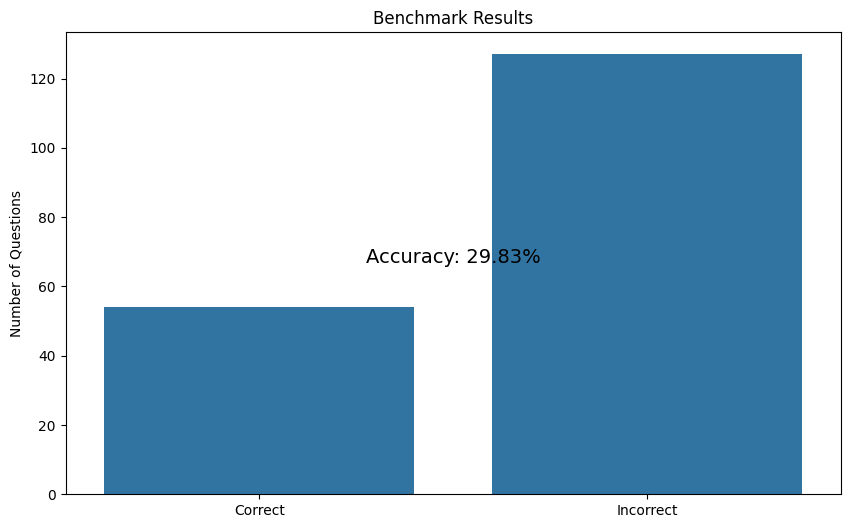

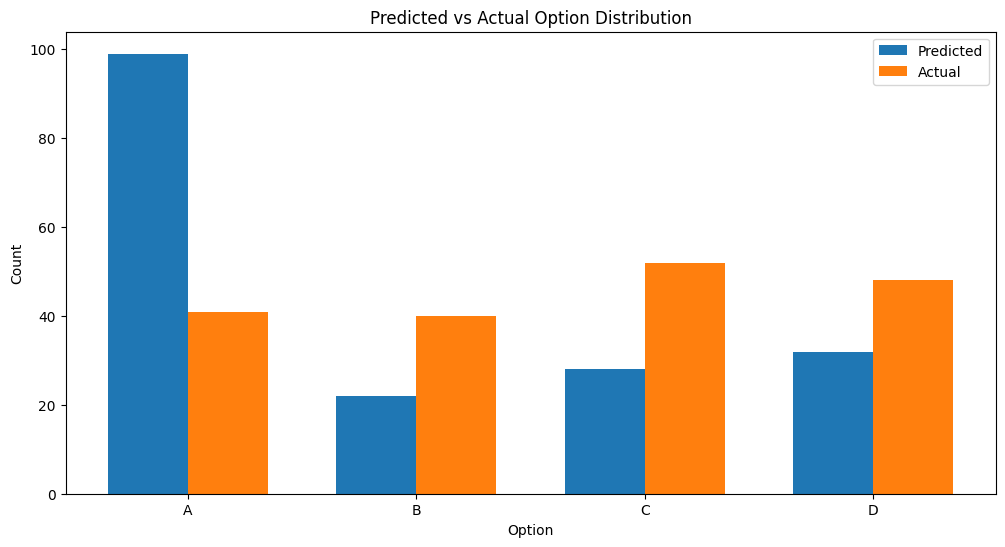

In [13]:
# 셀 12: 결과 시각화 (선택사항)
import matplotlib.pyplot as plt
import seaborn as sns

# 가장 최근 결과 파일 찾기
import glob
result_files = glob.glob("results/criminal_law_results_184342.csv")
if result_files:
    latest_result_file = max(result_files, key=os.path.getctime)
    
    # 결과 데이터 로드
    results_df = pd.read_csv(latest_result_file)
    
    # 정확도 시각화
    plt.figure(figsize=(10, 6))
    sns.barplot(x=['Correct', 'Incorrect'], y=[
        results_df['is_correct'].sum(), 
        len(results_df) - results_df['is_correct'].sum()
    ])
    plt.title('Benchmark Results')
    plt.ylabel('Number of Questions')
    accuracy = results_df['is_correct'].mean()
    plt.annotate(f'Accuracy: {accuracy:.2%}', 
                xy=(0.5, 0.5), 
                xycoords='axes fraction', 
                fontsize=14, 
                ha='center')
    plt.show()
    
    # 예측 분포 시각화
    plt.figure(figsize=(12, 6))
    pred_counts = results_df['predicted'].value_counts().sort_index()
    actual_counts = results_df['actual'].value_counts().sort_index()
    
    # 모든 옵션 (A, B, C, D) 포함
    all_options = sorted(list(set(pred_counts.index) | set(actual_counts.index)))
    
    x = range(len(all_options))
    width = 0.35
    
    plt.bar([i - width/2 for i in x], 
            [pred_counts.get(opt, 0) for opt in all_options], 
            width, 
            label='Predicted')
    plt.bar([i + width/2 for i in x], 
            [actual_counts.get(opt, 0) for opt in all_options], 
            width, 
            label='Actual')
    
    plt.xlabel('Option')
    plt.ylabel('Count')
    plt.title('Predicted vs Actual Option Distribution')
    plt.xticks(x, all_options)
    plt.legend()
    plt.show()